<h1><center>Лабораторная работа № 2</center></h1>
<h3><center>"Python"</center></h3>


### Задание:

Необходимо реализовать скрипт, выполняющий следующие действия:

**1\. Скачивание 1000 последних объявлений с hh.ru**

Для выполнения этого пункта вам понадобится библиотека requests. С помощью этой библиотеки можно делать HTTP-запросы в API hh.ru.

Вам понадобится этот метод. Чтобы тестировать запросы в api и смотреть, что они возвращают, можно использовать Postman. В качестве поискового запроса можно вводить ключевые слова, связанные с тематикой анализа данных: machine learning, data science, машинное обучение, big data, data analytics и тд. В ответе API будут интересующие нас поля: salary, area, name, employer

**2\. Получить медианное значение зарплат**
  
Необходимо сделать обработку полученных на первом шаге данных и получить следующую структуру: Словарь, где ключом является название вакансии (как оно задано на hh.ru), а значением - медианное значение зарплаты по этой вакансии. То есть необходимо сгруппировать данные по имени вакансии. Также можно использовать другие варианты, например, сгруппировать по городу или любому другому интересному параметру из выдачи. В поле salary hh.ru отдает значения диапазона. Значением зарплаты считать среднее значение из диапазона, например, если зп от 100 до 150, то фиксировать значение 125.

**3\. Получить распределение зарплат по диапазонам**

Необходимо выделить диапазоны зарплат, например:
до 80к, 80-120к, 120-150к, 150-200к, 200-300к, 300к+ Для каждого диапазона подсчитать количество предлагаемых вакансий.
*. Построить графики по пунктам 2 и 3

Построить гистограммы распределений с легендой и подписями осей с использованием библиотек matplotlib или seaborn



### Решение:

# Imports

In [1]:
import hhVacancies as hhv
import hhVacancies.sql as hhsql
import simpleCurrency as sc
import sqlite3
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import cm

#### Make plot outputs appear and be stored within the notebook

In [2]:
%matplotlib inline

# Constants

In [3]:
SEARCH_REQUEST = ('"machine learning" OR "data science" OR "машинное обучение" OR '
                  '"big data" OR "data analytics"')
SEARCH_AREAS = ['113', '16', '5']  # Russia, Belarus and Ukraine
SEARCH_RESULT_ORDER = 'publication_time'
SEARCH_RESULT_PER_PAGE = '100'
# VACANCIES_LIMIT = 1000

BASE_CURRENCY = 'RUB'
MEDIAN_GROUP_BY = 'City'
SALARY_LOWER_BOUND = 0
SALARY_RANGE_STEP = 30000
DF_HEAD_SIZE = 6

CUSTOM_FONT_NAME = 'PT Sans'
CUSTOM_FONT_SIZE = 12
CUSTOME_FIGURE_SIZE = (15,10)

# Dowloading vacancies from hh.ru

In [4]:
params = {
    'text': SEARCH_REQUEST,
    'area': SEARCH_AREAS,
    'only_with_salary': 'true',
    'order_by': SEARCH_RESULT_ORDER,
    'per_page': SEARCH_RESULT_PER_PAGE,
    }

vacancies_ids = hhv.get_vacancies_ids(**params)
print('Кол-во найденных вакансий: {}'.format(str(len(vacancies_ids))))

succed = hhsql.vacancies_to_db(vacancies_ids, recreate=True)  # saving all found vacancies to sqlite3 database
succed

  0%|          | 0/5 [00:00<?, ?it/s]

Getting the list of vacancies'IDs issued by the search query.
Reading pages:


  0%|          | 0/413 [00:00<?, ?it/s]

Кол-во найденных вакансий: 413


100%|██████████| 413/413 [18:24<00:00,  2.67s/it]


True

# Reading sqlite query results into a pandas DataFrame

In [5]:
conn = sqlite3.connect(hhsql.DB_FILE_PATH)

In [6]:
vac = pd.read_sql_query("""SELECT v.name AS [Vacancy_name], a.name AS [City],
                        s.from_ AS [Salary_from],s.to_ AS [Salary_to], s.currency AS [Currency]
                        FROM vacancy AS v
                        JOIN area AS a ON v.area_id = a.id
                        JOIN salary AS s ON v.salary_id = s.id""",
                        conn)
conn.close()

# DataFrame's head

In [7]:
vac.head(DF_HEAD_SIZE)

,Vacancy_name,City,Salary_from,Salary_to,Currency
0,Computer Vision developer / Разработчик компью...,Москва,250000.0,NaN,RUR
1,Программист Python,Санкт-Петербург,50000.0,NaN,RUR
2,Senior Front-End/JavaScript Developer,Санкт-Петербург,160000.0,NaN,RUR
3,Начальник смены склада,Минск,800.0,NaN,BYR
4,Инженер-программист (Java),Казань,50000.0,100000.0,RUR
5,UI/UX дизайнер (веб\мобильное приложение),Санкт-Петербург,100000.0,NaN,RUR


# Analyze of data types

In [8]:
vac.dtypes

Vacancy_name     object
City             object
Salary_from     float64
Salary_to       float64
Currency         object
dtype: object

In [9]:
vac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 5 columns):
Vacancy_name    413 non-null object
City            413 non-null object
Salary_from     345 non-null float64
Salary_to       238 non-null float64
Currency        413 non-null object
dtypes: float64(2), object(3)
memory usage: 16.2+ KB


In [10]:
vac.shape

(413, 5)

# Processing null values

In [11]:
vac.Salary_from = vac.Salary_from.fillna(value=vac.Salary_to)
vac.Salary_to = vac.Salary_to.fillna(value=vac.Salary_from)

In [12]:
vac.head(DF_HEAD_SIZE)

,Vacancy_name,City,Salary_from,Salary_to,Currency
0,Computer Vision developer / Разработчик компью...,Москва,250000.0,250000.0,RUR
1,Программист Python,Санкт-Петербург,50000.0,50000.0,RUR
2,Senior Front-End/JavaScript Developer,Санкт-Петербург,160000.0,160000.0,RUR
3,Начальник смены склада,Минск,800.0,800.0,BYR
4,Инженер-программист (Java),Казань,50000.0,100000.0,RUR
5,UI/UX дизайнер (веб\мобильное приложение),Санкт-Петербург,100000.0,100000.0,RUR


# Adding a column with average values of salaries

In [13]:
vac.insert(4, 'Average_salary', vac.apply(lambda row: (row.Salary_from + row.Salary_to) / 2, axis=1))

In [14]:
vac.head(DF_HEAD_SIZE)

,Vacancy_name,City,Salary_from,Salary_to,Average_salary,Currency
0,Computer Vision developer / Разработчик компью...,Москва,250000.0,250000.0,250000.0,RUR
1,Программист Python,Санкт-Петербург,50000.0,50000.0,50000.0,RUR
2,Senior Front-End/JavaScript Developer,Санкт-Петербург,160000.0,160000.0,160000.0,RUR
3,Начальник смены склада,Минск,800.0,800.0,800.0,BYR
4,Инженер-программист (Java),Казань,50000.0,100000.0,75000.0,RUR
5,UI/UX дизайнер (веб\мобильное приложение),Санкт-Петербург,100000.0,100000.0,100000.0,RUR


# Correction of incorrect abbreviations of currencies

In [15]:
def correct_currency(name):
    if name == 'RUR':
        return 'RUB'
    elif name == 'BYR':
        return 'BYN'
    return name

vac.Currency = vac.Currency.map(correct_currency)

In [16]:
vac.head(DF_HEAD_SIZE)

,Vacancy_name,City,Salary_from,Salary_to,Average_salary,Currency
0,Computer Vision developer / Разработчик компью...,Москва,250000.0,250000.0,250000.0,RUB
1,Программист Python,Санкт-Петербург,50000.0,50000.0,50000.0,RUB
2,Senior Front-End/JavaScript Developer,Санкт-Петербург,160000.0,160000.0,160000.0,RUB
3,Начальник смены склада,Минск,800.0,800.0,800.0,BYN
4,Инженер-программист (Java),Казань,50000.0,100000.0,75000.0,RUB
5,UI/UX дизайнер (веб\мобильное приложение),Санкт-Петербург,100000.0,100000.0,100000.0,RUB


# Converting foreign currencies to ruble (for average salaries)

In [17]:
conv_column_name = "Average_salary_{}".format(BASE_CURRENCY)

currencies = vac.Currency.unique()
conv = sc.CurrencyConverter(currencies, [BASE_CURRENCY,])
vac[conv_column_name] = vac.apply(lambda row: conv.convert(row.Average_salary, row.Currency, BASE_CURRENCY), axis=1)

In [18]:
vac.head(26)

,Vacancy_name,City,Salary_from,Salary_to,Average_salary,Currency,Average_salary_RUB
0,Computer Vision developer / Разработчик компью...,Москва,250000.0,250000.0,250000.0,RUB,250000.00
1,Программист Python,Санкт-Петербург,50000.0,50000.0,50000.0,RUB,50000.00
2,Senior Front-End/JavaScript Developer,Санкт-Петербург,160000.0,160000.0,160000.0,RUB,160000.00
3,Начальник смены склада,Минск,800.0,800.0,800.0,BYN,21680.00
4,Инженер-программист (Java),Казань,50000.0,100000.0,75000.0,RUB,75000.00
5,UI/UX дизайнер (веб\мобильное приложение),Санкт-Петербург,100000.0,100000.0,100000.0,RUB,100000.00
6,Графический дизайнер в отдел маркетинга,Санкт-Петербург,50000.0,50000.0,50000.0,RUB,50000.00
7,Системный администратор/DevOps-инженер,Санкт-Петербург,60000.0,60000.0,60000.0,RUB,60000.00
8,Python разработчик,Ярославль,40000.0,60000.0,50000.0,RUB,50000.00
9,Business Development Manager,Москва,80000.0,100000.0,90000.0,RUB,90000.00


# Getting the median values of salaries grouped by city

In [19]:
median_col_name = "Median salary in '{}'".format(BASE_CURRENCY)
ms = pd.DataFrame({median_col_name: vac.groupby(MEDIAN_GROUP_BY)[conv_column_name].median()}).reset_index()

In [20]:
ms

,City,Median salary in 'RUB'
0,Абакан,175000.0
1,Архангельск,102500.0
2,Белгород,40000.0
3,Брянск,30000.0
4,Великий Новгород,38000.0
5,Вологда,65000.0
6,Воронеж,96930.0
7,Екатеринбург,120000.0
8,Ижевск,70000.0
9,Казань,87500.0


#### Constructing a histogram with median salary values in descending order:

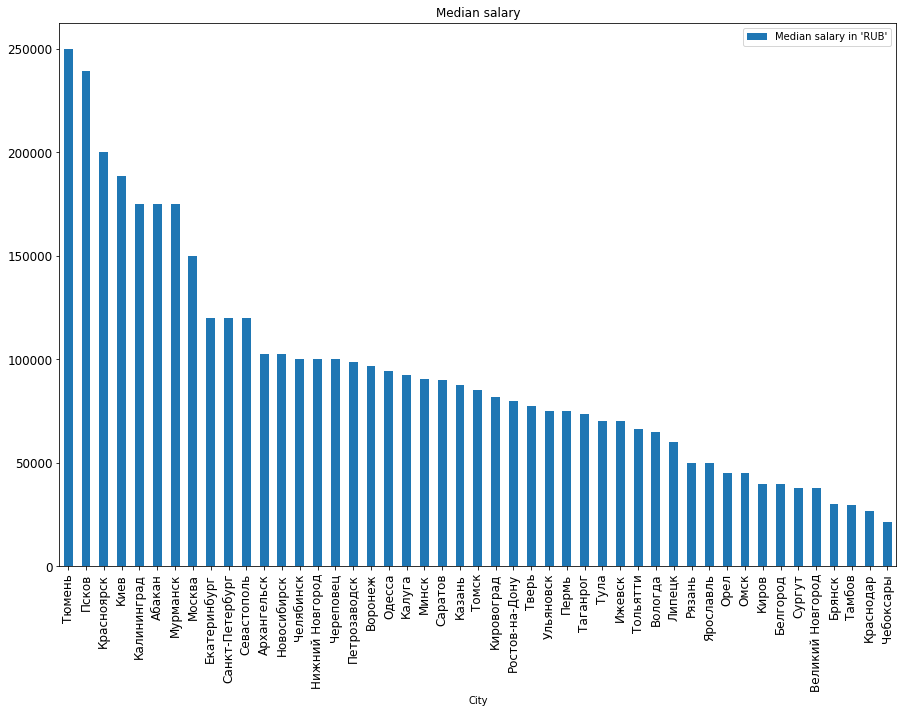

In [21]:
ms_bar_title = 'Median salary'
ms.sort_values(median_col_name, ascending=False).plot.bar(x=MEDIAN_GROUP_BY, title=ms_bar_title,
                                                          figsize=CUSTOME_FIGURE_SIZE, fontsize=CUSTOM_FONT_SIZE)

## Creating the same bar with pyplot

### Adding a new column ("number of vacancies") to the existing dataframe "ms"

In [22]:
# vac['City'].value_counts()

In [23]:
count_column_name = "Number of vacancies"
cvs = pd.DataFrame({count_column_name: vac.groupby(MEDIAN_GROUP_BY)[conv_column_name].size()}).reset_index()
cvs.head(DF_HEAD_SIZE)

,City,Number of vacancies
0,Абакан,1
1,Архангельск,2
2,Белгород,1
3,Брянск,1
4,Великий Новгород,5
5,Вологда,1


In [24]:
ms = pd.merge(ms, cvs, on=MEDIAN_GROUP_BY)

In [25]:
ms

,City,Median salary in 'RUB',Number of vacancies
0,Абакан,175000.0,1
1,Архангельск,102500.0,2
2,Белгород,40000.0,1
3,Брянск,30000.0,1
4,Великий Новгород,38000.0,5
5,Вологда,65000.0,1
6,Воронеж,96930.0,6
7,Екатеринбург,120000.0,15
8,Ижевск,70000.0,2
9,Казань,87500.0,6


### Matplotlib custom settings

In [26]:
matplotlib.rcParams["figure.figsize"] = list(CUSTOME_FIGURE_SIZE)
# matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams.update({"font.size": CUSTOM_FONT_SIZE})

### Formatter for currency axis

In [27]:
def thousands(x, pos):
    """The two args are the value and tick position"""
    return '%1.0fk' % (x * 1e-3)

formatter = FuncFormatter(thousands)

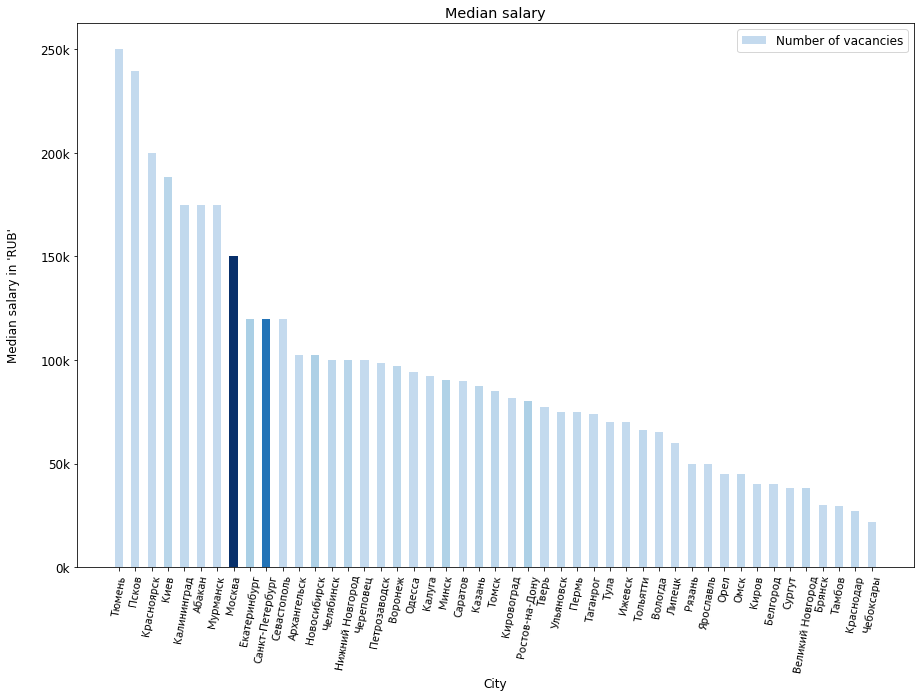

In [28]:
sc = ms.sort_values(median_col_name, ascending=False)

cities = sc[MEDIAN_GROUP_BY].tolist()
x_pos = np.arange(len(cities))

median_salaries = sc[median_col_name].tolist()
vacancies_count = sc[count_column_name].tolist()

# colors = cm.jet(np.linspace(0, 0.3, len(cities)))
# colors = cm.Blues(np.linspace(1, 0, len(cities)))
colors = cm.Blues(np.array(vacancies_count) / max(vacancies_count) + 0.25)

plt.bar(left=x_pos, height=median_salaries, width=0.5, color=colors)

plt.xticks(x_pos, cities, rotation=80, fontname=CUSTOM_FONT_NAME, fontsize=CUSTOM_FONT_SIZE)
plt.xlabel(MEDIAN_GROUP_BY)
plt.ylabel(median_col_name, labelpad=20)
plt.title(ms_bar_title)
plt.legend([count_column_name])

axis = plt.gca()
axis.yaxis.set_major_formatter(formatter)
plt.figure(dpi=600)

# Geting the distribution of salaries by ranges

In [29]:
max_salary = vac[conv_column_name].max()
count_arrage = np.arange(SALARY_LOWER_BOUND, max_salary + SALARY_RANGE_STEP, SALARY_RANGE_STEP)
si = pd.DataFrame({count_column_name: vac.groupby(pd.cut(vac[conv_column_name], count_arrage)).size()}).reset_index()

In [30]:
si

,Average_salary_RUB,Number of vacancies
0,"(0.0, 30000.0]",26
1,"(30000.0, 60000.0]",62
2,"(60000.0, 90000.0]",74
3,"(90000.0, 120000.0]",71
4,"(120000.0, 150000.0]",65
5,"(150000.0, 180000.0]",32
6,"(180000.0, 210000.0]",41
7,"(210000.0, 240000.0]",15
8,"(240000.0, 270000.0]",7
9,"(270000.0, 300000.0]",8


In [31]:
si = si.ix[si['Number of vacancies'] >= 3]  # delete rows from the dataframe if a cell contains a value less than 3

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [32]:
si

,Average_salary_RUB,Number of vacancies
0,"(0.0, 30000.0]",26
1,"(30000.0, 60000.0]",62
2,"(60000.0, 90000.0]",74
3,"(90000.0, 120000.0]",71
4,"(120000.0, 150000.0]",65
5,"(150000.0, 180000.0]",32
6,"(180000.0, 210000.0]",41
7,"(210000.0, 240000.0]",15
8,"(240000.0, 270000.0]",7
9,"(270000.0, 300000.0]",8


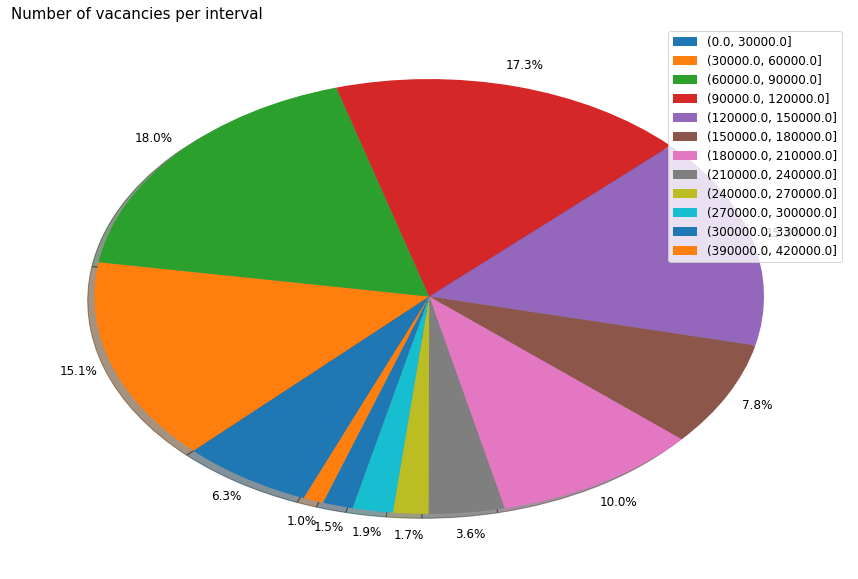

In [33]:
values = si[count_column_name].tolist()
labels = si[conv_column_name].tolist()
# colors = cm.rainbow(np.linspace(0, 0.8, len(labels)))

plt.pie(values, labels=None, autopct='%1.1f%%', pctdistance=1.1, startangle=248, 
        counterclock=False, shadow=True)
plt.legend(labels, loc=1)
plt.title(count_column_name + ' per interval', loc='left', fontsize=15)
plt.show()


In [34]:
# si.plot.pie(y=count_column_name, labels=None, legend=si[conv_column_name].tolist(), autopct='%1.1f%%', 
#            pctdistance=1.1, labeldistance=1.2, figsize=CUSTOME_FIGURE_SIZE, shadow=True, startangle=248)

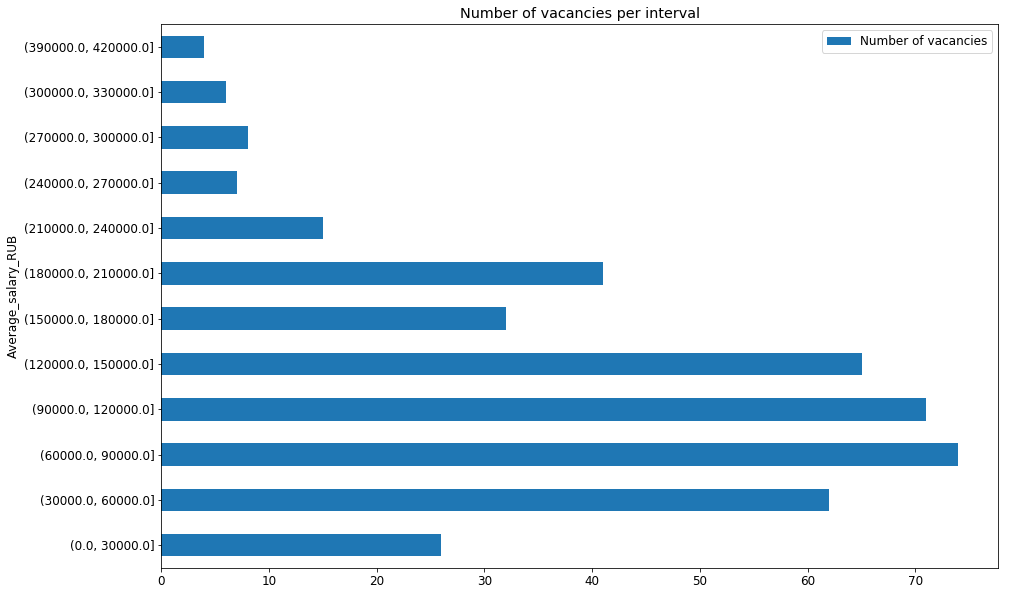

In [35]:
si_bar_title = "Number of vacancies per interval"
si.plot.barh(x=conv_column_name, title=si_bar_title, figsize=CUSTOME_FIGURE_SIZE, fontsize=CUSTOM_FONT_SIZE)